# House Price Analysis with Linear Regression

--------------------------------------------

The focus of this project will be centered around first time home buyers. 

## Data Cleaning
Data is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

What are all these columns?
Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - date house was sold
* **price** - price is prediction target
* **bedrooms** - number of Bedrooms/House
* **bathrooms** - number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** -  square footage of the lot
* **floors** - total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has a view
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


### Datetime

The "date" column is currently an object. Let's change it to datetime, then extract the month and year so we can use those easily. Then, drop the original date column.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

### Odd values 

In [7]:
df.sqft_basement.value_counts(normalize= True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
3500.0    0.000046
704.0     0.000046
2810.0    0.000046
506.0     0.000046
666.0     0.000046
Name: sqft_basement, Length: 304, dtype: float64

0.2% of the data is marked as '?' while 59.3% is marked as '0.0'. 

In [8]:
# change ? in column to 0 - most commonly seen value
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [9]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
3500.0        1
704.0         1
2810.0        1
506.0         1
666.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [10]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float64')

In [11]:
# see how many rows have a value for sqft_basement
len (df.loc[df['sqft_basement'] > 0])

8317

Let's look elsewhere and see if there is anything else odd.

In [12]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,6.573969,2014.322962
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,3.115061,0.467619
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,2014.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000,2014.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000,2014.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,2015.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,2015.000000


That house with 33 bedrooms is definitely odd. Let's check it out.

In [13]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
# Let's look at any house that had 10+ bedrooms and see how the 
# house with 33 bedrooms compares
df[df['bedrooms'] >= 10]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
8748,1773100755,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,8,2014
13301,627300145,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400,8,2014
15147,5566100170,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914,10,2014
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,6,2014
19239,8812401450,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745,12,2014


Some ways it doesn't differ too much from the other houses:
* best condition
* similar grade
* median in terms of lot size
* fairly similar number of bathrooms

But, in some ways, it is concerning:
* lowest amount of square footage
* only 1 story / floor
* only 1.75 bathrooms for 33 rooms?
* But, mainly, 33 rooms?!? 

It's too suspicious. Let's just remove it.

In [15]:
# Drop the 33 bedroom house then verify that it is gone
df.drop(index=15856, inplace= True)
# df[df['bedrooms'] >= 10]

### Null values

In [16]:
# look at values in waterfront
df.waterfront.value_counts(normalize= True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [17]:
# look at values in view
df.view.value_counts(normalize= True)

0.0    0.901918
2.0    0.044443
3.0    0.023592
1.0    0.015325
4.0    0.014722
Name: view, dtype: float64

In [18]:
# look at values in yr_renovated column
df.yr_renovated.value_counts(normalize= True)

0.0       0.958094
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

99.2% of homes are not considered waterfront properties.

90% of homes do not have a view. While there are more categories, and replacing the null values with 0 may still be iffy, there are not very many missing values.

95.8% of homes have never been renovated. 

We can feel secure in replacing those all the missing values with zeros.

In [19]:
df.fillna(0, inplace= True)

### Duplicates

Most columns will likely have duplicates - especially the categorical columns. But the 'id' should have only one id per entry. Let's check that out.

In [20]:
# check id column for duplicate entries
df.id.duplicated().sum()

177

In [21]:
df_id_dups = df[df.duplicated('id')]

In [22]:
df_id_dups.reset_index(drop= True, inplace= True)

In [23]:
df.loc[df['id'] == 6021501535]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
93,6021501535,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,7,2014
94,6021501535,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,12,2014


In [24]:
df.loc[df['id'] == 4139480200]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,6,2014
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,12,2014


In [25]:
df.loc[df['id'] == 3969300030]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
345,3969300030,165000.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,7,2014
346,3969300030,239900.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,12,2014


It looks like the rows that have identical id numbers were sold a few months apart. I'm going to drop the older data. (AKA the first entries)

In [26]:
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [27]:
df.id.duplicated().sum()

0

In [28]:
df.reset_index(inplace= True, drop= True)

Great! We took care of duplicates, null values, odd values, and have correct data types.

We can move on to taking a closer look at the data.

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Data visualization is the graphical representation of data in order to interactively and efficiently convey insights to others.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21419 entries, 0 to 21418
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21419 non-null  int64  
 1   price          21419 non-null  float64
 2   bedrooms       21419 non-null  int64  
 3   bathrooms      21419 non-null  float64
 4   sqft_living    21419 non-null  int64  
 5   sqft_lot       21419 non-null  int64  
 6   floors         21419 non-null  float64
 7   waterfront     21419 non-null  float64
 8   view           21419 non-null  float64
 9   condition      21419 non-null  int64  
 10  grade          21419 non-null  int64  
 11  sqft_above     21419 non-null  int64  
 12  sqft_basement  21419 non-null  float64
 13  yr_built       21419 non-null  int64  
 14  yr_renovated   21419 non-null  float64
 15  zipcode        21419 non-null  int64  
 16  lat            21419 non-null  float64
 17  long           21419 non-null  float64
 18  sqft_l

### Questions?

Given the information we have and that we are looking at data that would be interesting to first time home buyers, let's generate some questions that might conclude some interesting answers.

1. Which season is best to buy a house if you want the lowest price?
2. Does a waterfront or view matter? Could a first time home buyer afford that?
3. Are there some grades or conditions that might be out of reach for a first time home buyer?
4. Is there an area that we can focus on or eliminate?

#### Criteria assumptions
Before we dive into those questions, it would be helpful to get rid of the information that is not pertinent to a first time home buyer. These could be things like:
* houses over a certain price
* houses with a large square footage
* houses with a lot of bedrooms

So, let's work on removing the irrelevant data.

<AxesSubplot:xlabel='price'>

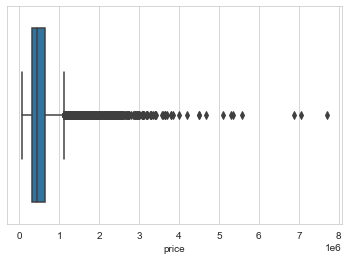

In [30]:
#  Visualize price and outliers
#  Assume for first time home buyer - budget is not more than $500,000
sns.boxplot(x= df['price'])

In [31]:
# remove houses that sold for > $800,000
df = df[df['price'] <= 800000]

<AxesSubplot:xlabel='sqft_living'>

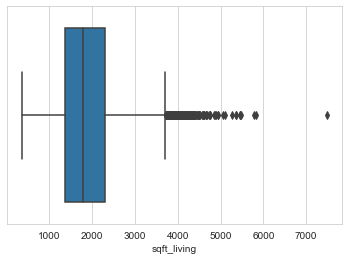

In [32]:
# Visualize houses with high square footage
sns.boxplot(x= df['sqft_living'])

In [33]:
# Whoa! Those are some large houses! Let's cut out the outliers
df = df[df['sqft_living'] <= 4000]

<AxesSubplot:xlabel='bedrooms'>

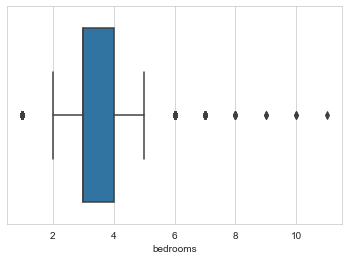

In [34]:
# Visualize bedrooms after houses with large price tags were removed
sns.boxplot(x= df['bedrooms'])

In [35]:
# remove houses with more than 6 bedrooms
df = df[df['bedrooms'] <= 6]

#### 1. Which season is best to buy a house if you want the lowest price?

To answer this question, we will have to break the months up into seasons. Then we will find which season has the lowest average sale price.

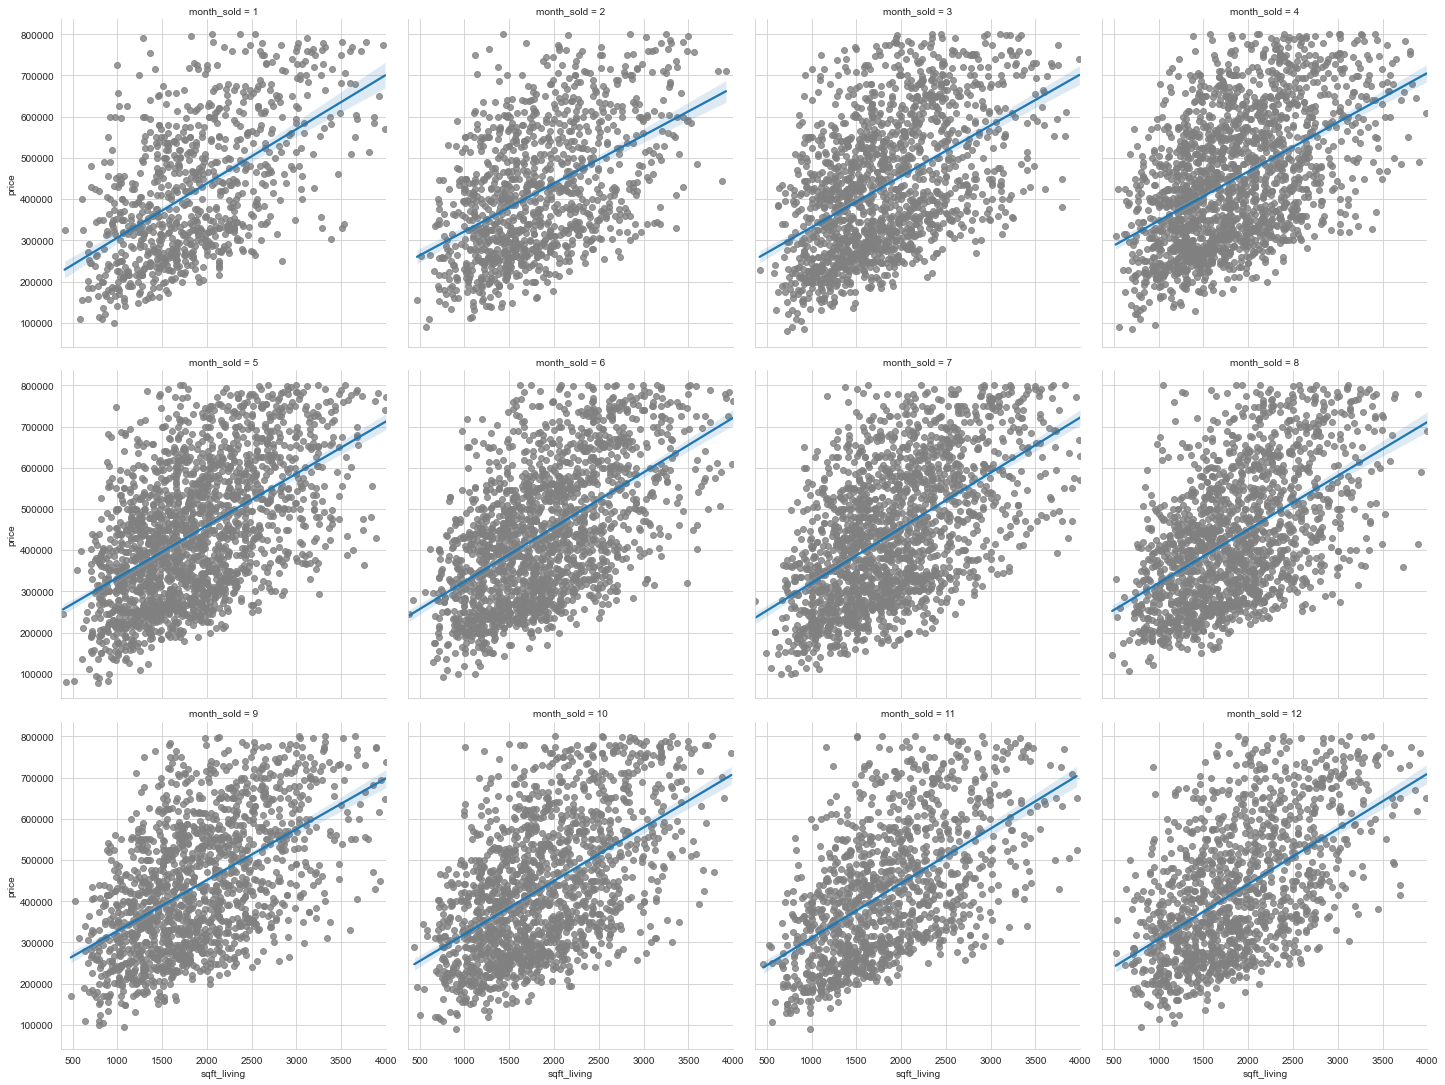

In [36]:
# First, let's look at the months and see if there appears to be a trend
g1 = sns.lmplot(x= 'sqft_living', y= 'price', data= df, col= 'month_sold', 
               col_wrap= 4, scatter_kws = {'color': 'gray'})

In [37]:
# set columns for months sold
df.loc[(df['month_sold'] >= 4) & (df['month_sold'] <= 6), 'season'] = 'spring'
df.loc[(df['month_sold'] >= 7) & (df['month_sold'] <= 9), 'season'] = 'summer'
df.loc[(df['month_sold'] == 10) | (df['month_sold'] == 11), 'season'] = 'fall'
df.loc[(df['month_sold'] == 12), 'season'] = 'winter1'
df.loc[(df['month_sold'] <= 3), 'season'] = 'winter2'

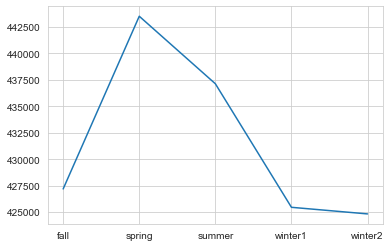

In [38]:
plt.plot(df.groupby('season')['price'].mean().round(2))

<AxesSubplot:xlabel='season', ylabel='price'>

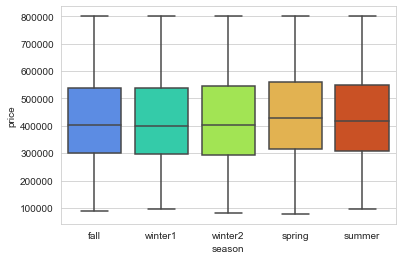

In [39]:
sns.boxplot(x= 'season', y= 'price', data= df, palette= 'turbo')

In [40]:
df_s = df.groupby('season')['price'].mean().round(2)
df_s

season
fall       427192.15
spring     443511.71
summer     437131.97
winter1    425455.78
winter2    424830.72
Name: price, dtype: float64

The most expensive season to buy a house is in spring - April through June - with the average sale price with our criteria being $443,511.71

The least expensive season to buy a house is in "winter2" or the months January through March.
The average home with our search criteria sold for $424,830.72

When comparing the line graph to the boxplot, you can now see that the amount you would be saving is difficult to see in some seasons. The savings would be about $18,000-19,000 between the least expensive time of year (January - March) and the most expensive (April - June). 

However, it is interesting to see that fall, winter1, and winter2 don't vary that much from each other. During October through March, one might expect to pay only 2K-3K more or less.

#### 2. Does a waterfront or view matter? Could a first time home buyer afford that?

Let's see how many waterfront properties or houses with views we have. When we took out higher priced homes, it may not have left much data in those features.

In [41]:
print(len(df[df['waterfront'] == 1]))
len(df[df['view'] > 0])

35


1140

In [42]:
len(df[df['waterfront'] == 1]) / len(df)

0.0019066296235768373

There were only 35 properties that were sold in the first time home buyer's criteria. If they really want a waterfront property, they may have to wait a while.

In [43]:
len(df[df['view'] > 0]) / len(df)

0.062101650596502696

While 6% of the data is still a small portion, we can leave it and see what the analysis says.

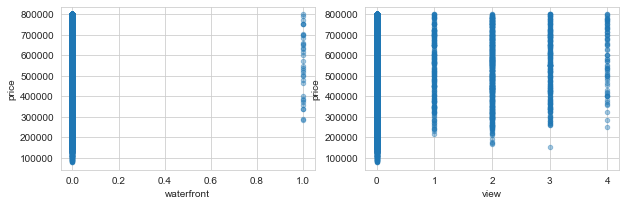

In [44]:
fig, axes = plt.subplots(nrows= 1, ncols= 2, figsize= (10, 3))

for xcol, ax in zip([ 'waterfront', 'view'], axes):
    df.plot(kind= 'scatter', x=xcol, y= 'price', ax=ax, alpha= 0.4)

Looks like getting a house with a view could still be a possibility. It appears that there are some houses priced around $200,000 that have a view rated "2"

#### 3. Are there some grades or conditions that might be out of reach for a first time home buyer?

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

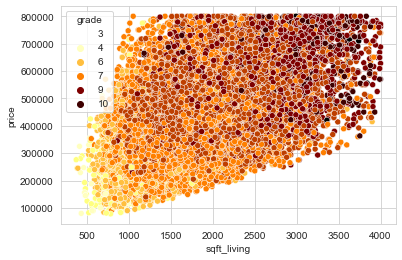

In [45]:
sns.scatterplot(x= 'sqft_living', y= 'price', hue= 'grade', data= df, 
                palette= 'afmhot_r')

Grades do seem to improve with price, but there are some smaller and less expensive homes that have higher grades.

0.0014708285667592745

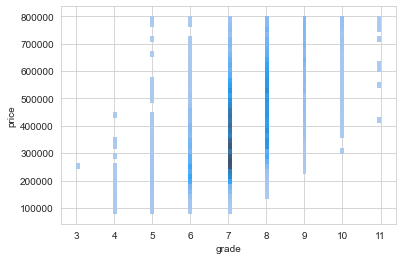

In [46]:
# #Looking at grades of the houses
sns.histplot(x= 'grade', y= 'price', data= df)

# percent of houses sold with a grade "4"
len(df[df['grade'] == 4]) / len(df)

0.010023424306803945

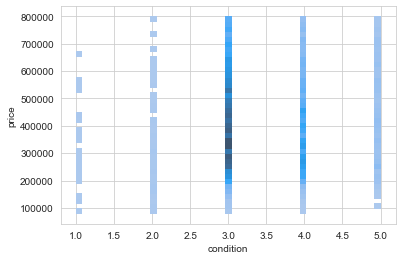

In [47]:
sns.histplot(x= 'condition', y= 'price', data= df)
# percent of houses with a condition of "1 or "2" 
len(df[df['condition'] <= 2]) / len(df)

In [48]:
df.condition.unique()

array([3, 5, 4, 1, 2])

While we may not want a first time home buyer to buy a house in poor condition, there are not many houses that would qualify. Since condition and grade can be subjective, we can leave them in and let the potential new home owner decide.

#### 4. Is there an area that we can focus on or eliminate?

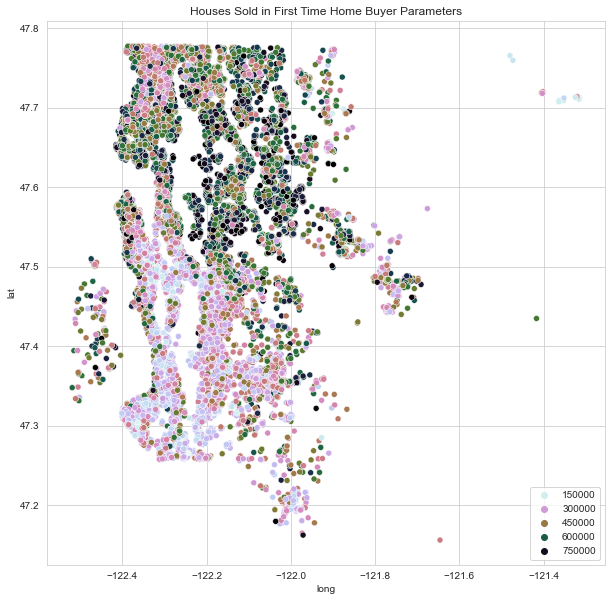

In [49]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix_r')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

Appears that the houses that sold for more are on the Northern side. We can separate the areas to see if we are correct.

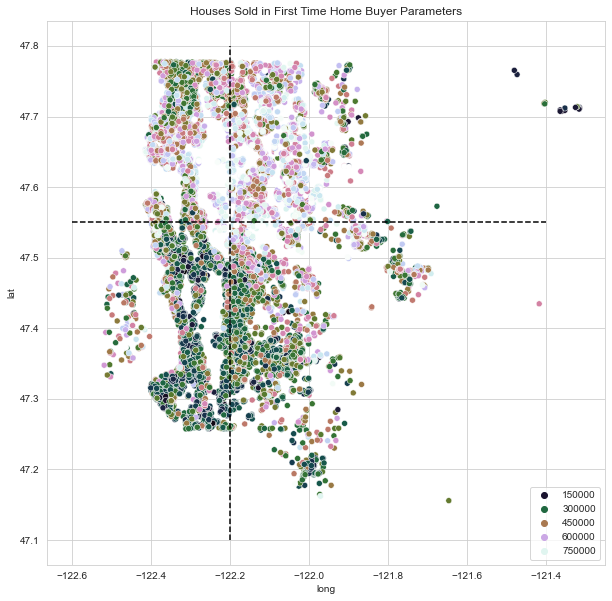

In [50]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix')
plt.hlines(y=47.55, xmin=-122.6, xmax=-121.4, colors='black', linestyle='--')
plt.vlines(x=-122.2, ymin=47.1, ymax=47.8, colors='black', linestyle='--')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

That appears to separate the areas fairly evenly. Let's turn the latitude and longitude into quadrants and use the quadrants instead of zipcodes as locators.

In [51]:
df.loc[(df['lat'] >= 47.5) & (df['long'] >= -122.2), 'quadrant' ] = 'NW'
df.loc[(df['lat'] > 47.5) & (df['long'] < -122.2), 'quadrant' ] = 'NE'
df.loc[(df['lat'] <= 47.5) & (df['long'] <= -122.2), 'quadrant' ] = 'SW'
df.loc[(df['lat'] < 47.5) & (df['long'] > -122.2), 'quadrant' ] = 'SE'

In [52]:
# did it work?
# df_q3 = df[df['quadrant'] == 3]
# sns.scatterplot(x='long', y='lat', hue='price', data=df_q3, 
#                 palette= 'cubehelix')

The theory is that houses in quadrants 3 and 4 will be more affordable than those in quadrants 1 and 2.

<AxesSubplot:xlabel='quadrant', ylabel='price'>

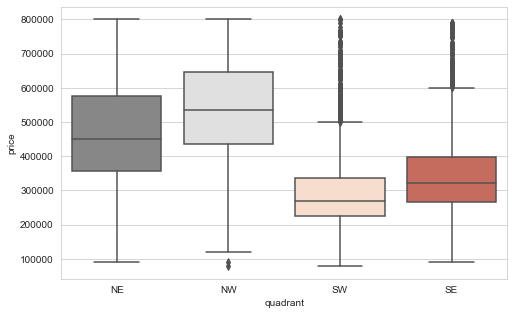

In [53]:
plt.figure(figsize= (8,5))
sns.boxplot(x= 'quadrant', y= 'price', data= df, palette= 'RdGy_r')

Looks like we were right. If we are only looking at homes that are less than $800,000, then houses in the Southern quadrants would, generally, be the least expensive.

## Feature Selection & Engineering

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

### Separate Continuous and Categorical Data

In [54]:
# use this to see which columns could be categorical or continuous data
continuous = []
categorical = []

for col in df.columns:
    if (df[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [55]:
continuous

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [56]:
categorical

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'month_sold',
 'year_sold',
 'season',
 'quadrant']

Almost perfect. But I think there are some columns labeled categorical that I would consider continuous.

In [57]:
# Continuous data
con = ['id', 'price', 'sqft_living', 'sqft_lot','sqft_basement', 'yr_built', 
       'zipcode','lat','long']

In [58]:
# Categorical data
cat = ['waterfront','view','condition','grade', 'month_sold', 'year_sold', 
       'season','quadrant', 'bedrooms','bathrooms','floors', 'yr_renovated']

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>]], dtype=object)

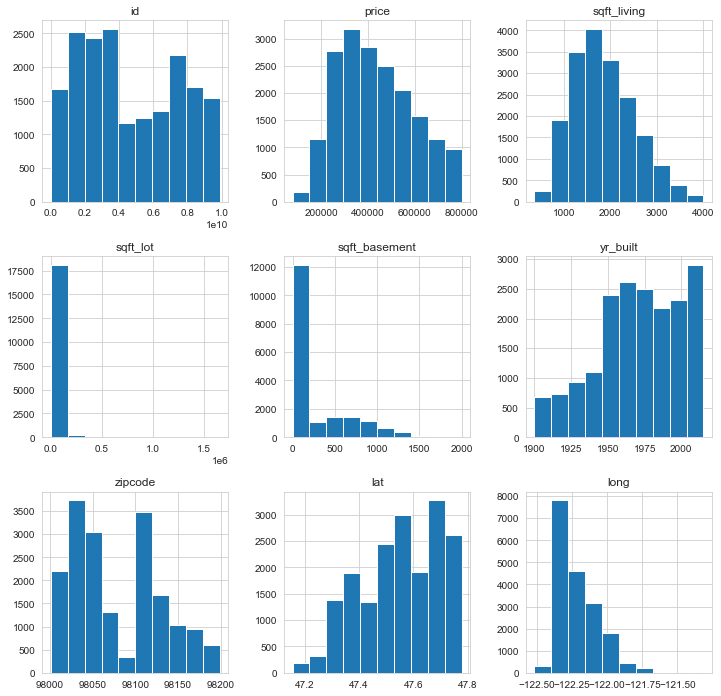

In [59]:
# Look at continuous variables
df_continuous = df.loc[:, con]
df_continuous.hist(figsize= (12, 12))

With the exception of "sqft_lot", these indeed look like they are continuous.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18357 entries, 0 to 21418
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             18357 non-null  int64  
 1   price          18357 non-null  float64
 2   bedrooms       18357 non-null  int64  
 3   bathrooms      18357 non-null  float64
 4   sqft_living    18357 non-null  int64  
 5   sqft_lot       18357 non-null  int64  
 6   floors         18357 non-null  float64
 7   waterfront     18357 non-null  float64
 8   view           18357 non-null  float64
 9   condition      18357 non-null  int64  
 10  grade          18357 non-null  int64  
 11  sqft_above     18357 non-null  int64  
 12  sqft_basement  18357 non-null  float64
 13  yr_built       18357 non-null  int64  
 14  yr_renovated   18357 non-null  float64
 15  zipcode        18357 non-null  int64  
 16  lat            18357 non-null  float64
 17  long           18357 non-null  float64
 18  sqft_l

array([[<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'month_sold'}>,
        <AxesSubplot:title={'center':'year_sold'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

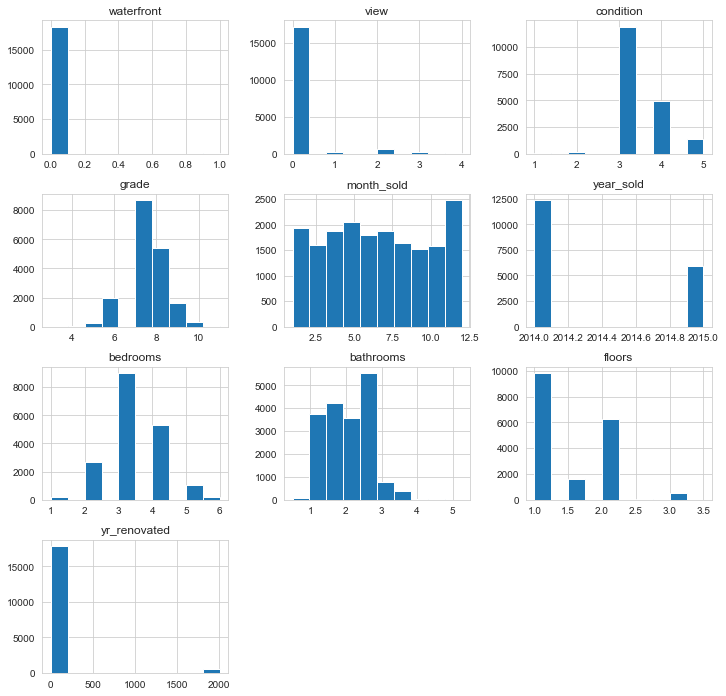

In [61]:
df_categorical = df.loc[:, cat]
df_categorical.hist(figsize= (12, 12))

Some of them could be cleaned up. But let's see what our baseline is and adjust from there.

### Baseline checks

#### Multicollinearity 

Check for interactions between other features.

In [62]:
corr = df.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
id,1.000000,0.036635,0.015343,0.037397,0.026249,-0.132084,0.038244,-0.007710,0.021511,-0.034465,0.052122,0.032067,-0.007151,0.031382,-0.009708,-0.005087,0.006363,0.020552,0.022918,-0.143875,-0.008659,0.005672
price,0.036635,1.000000,0.246182,0.385019,0.528360,0.077835,0.240402,0.034465,0.170890,0.028472,0.545791,0.429645,0.199413,0.052482,0.046712,0.004410,0.472174,0.073879,0.481853,0.069994,-0.006954,-0.001561
bedrooms,0.015343,0.246182,1.000000,0.481350,0.610580,0.018152,0.135297,-0.032910,0.012163,0.023756,0.301031,0.471946,0.269714,0.178217,-0.013274,-0.163818,-0.067911,0.151918,0.376477,0.015135,-0.004082,-0.003980
bathrooms,0.037397,0.385019,0.481350,1.000000,0.687900,0.035241,0.501888,-0.024657,0.045940,-0.143123,0.582541,0.606886,0.182012,0.578502,-0.003421,-0.223493,-0.047315,0.250721,0.501975,0.037941,0.012498,-0.028816
sqft_living,0.026249,0.528360,0.610580,0.687900,1.000000,0.129350,0.310159,-0.008900,0.113305,-0.072769,0.641929,0.828791,0.353889,0.365262,0.003073,-0.221420,-0.047584,0.289011,0.712792,0.147229,0.016968,-0.029754
sqft_lot,-0.132084,0.077835,0.018152,0.035241,0.129350,1.000000,-0.035021,0.016855,0.094488,0.005935,0.056592,0.133643,0.001660,0.022509,0.012945,-0.130390,-0.101120,0.215313,0.139380,0.710613,0.006610,-0.002562
floors,0.038244,0.240402,0.135297,0.501888,0.310159,-0.035021,1.000000,-0.012295,-0.024094,-0.284493,0.446946,0.519602,-0.321690,0.531871,-0.014880,-0.069429,0.017196,0.130334,0.244561,-0.037301,0.014936,-0.022869
waterfront,-0.007710,0.034465,-0.032910,-0.024657,-0.008900,0.016855,-0.012295,1.000000,0.273831,0.011387,-0.018670,-0.016956,0.013481,-0.037845,0.047059,0.029554,-0.038433,-0.056192,0.000405,0.038770,0.005525,-0.003695
view,0.021511,0.170890,0.012163,0.045940,0.113305,0.094488,-0.024094,0.273831,1.000000,0.021452,0.083454,0.033851,0.138147,-0.070803,0.038506,0.098622,-0.046730,-0.071943,0.145220,0.093728,-0.000033,0.005571
condition,-0.034465,0.028472,0.023756,-0.143123,-0.072769,0.005935,-0.284493,0.011387,0.021452,1.000000,-0.185679,-0.180649,0.168776,-0.345938,-0.048179,-0.008716,-0.022240,-0.086328,-0.131026,0.011206,0.026070,-0.048089


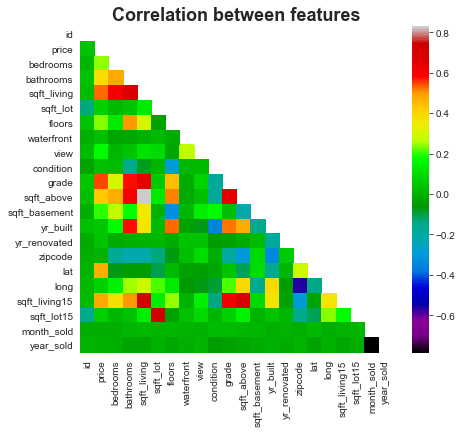

In [63]:
plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

There are some areas of high correlation. The highest is where "sqft_above" meets "sqft_living". "sqft_living15" also correlates highly across other features. Those will be columns we look forward to removing.

In [65]:
df.drop(columns= ['sqft_above', 'sqft_living15', 'month_sold',
                  'sqft_lot15', 'season', 'quadrant'], inplace= True)

In [69]:
df.info()

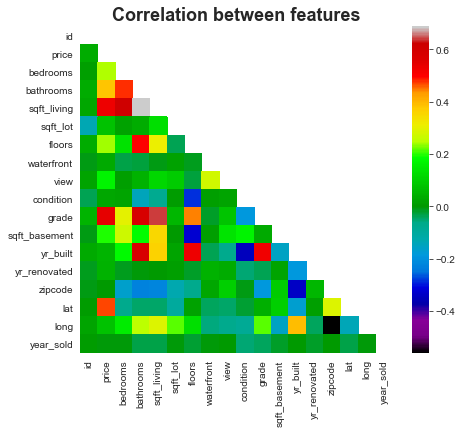

In [70]:
corr1 = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

#### Baseline Model

In [66]:
df1 = df.copy()
outcome = 'price'
x_cols = df1.drop(['price'], axis= 1).columns
x_cols

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'year_sold'],
      dtype='object')

In [67]:
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= df1).fit()

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1967.
Date:                Fri, 08 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:51   Log-Likelihood:            -2.3659e+05
No. Observations:               18357   AIC:                         4.732e+05
Df Residuals:                   18339   BIC:                         4.733e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.635e+07   3.39e+06    -10.715      0.000    -4.3e+07   -2.97e+07
id             8.293e-07   2.49e-07      3.328      0.001    3.41e-07    1.32e-06
bedrooms       -1.08e+04   1098.467     -9.835      0.000    -1.3e+04   -8650.239
bathrooms        2.3e+04   1796.993     12.801      0.000    1.95e+04    2.65e+04
sqft_living      79.5791      2.045     38.923      0.000      75.572      83.587
sqft_lot          0.2138      0.020     10.677      0.000       0.175       0.253
floors         2.552e+04   1894.567     13.470      0.000    2.18e+04    2.92e+04
waterfront     1.021e+05   1.69e+04      6.041      0.000     6.9e+04    1.35e+05
view           2.781e+04   1365.007     20.375      0.000    2.51e+04    3.05e+04
condition      2.049e+04   1215.049     16.867      0.000    1.81e+04    2.29e+04
grade          6.473e+04   1160.791     55.763      0.000    6.25e+04     6.7e+04
sqft_basement    -3.9035      2.500     -1.561      0.118      -8.804       0.997
yr_built      -1473.4675     39.252    -37.539      0.000   -1550.405   -1396.530
yr_renovated      4.0370      2.295      1.759      0.079      -0.462       8.536
zipcode        -161.0321     16.978     -9.485      0.000    -194.310    -127.754
lat            5.121e+05   5335.873     95.979      0.000    5.02e+05    5.23e+05
long           1.492e+04   6554.552      2.276      0.023    2071.072    2.78e+04
year_sold      1.598e+04   1514.007     10.557      0.000     1.3e+04     1.9e+04
==============================================================================
Omnibus:                      523.271   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.600
Skew:                           0.333   Prob(JB):                    2.97e-150
Kurtosis:                       3.675   Cond. No.                     2.61e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Baseline $R^{2}$ = 0.644

Let's see if we can't improve that a little (or a lot).

### One-hot encoding for categorical data

Okay. That second heatmap looks different than the one before! 

Time to work with the data within some of these features to clean it up.
Features we'll focus on are:
* bathrooms (integer)
* sqft_lot (< or > than certain area)
* floors (integer)
* yr_built  (bin)
* sqft_basement (Y or N)
* view (Y or N)
* yr_renovated (Y or N)

In [ ]:
# Get bathrooms to integer rather than float


In [ ]:
# Also, drop one from existing cat features: - use dummy variable
# waterfront
# condition
# grade
# quadrant

In [ ]:
# g = sns.pairplot(df[['price', 'sqft_living', 'yr_built','zipcode']], 
#                  hue= 'price', palette= 'deep', height= 5)

## Modeling and Prediction

### Baseline Model

In [ ]:
# df.drop()

### Train test split

### Improving baseline model

In [ ]:
# get rid of columns you won't use
# https://www.youtube.com/watch?v=8_Le51miL-8
# https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

In [71]:
# log transform

In [ ]:
# df2 = df1[['price', 'waterfront', 'yr_built', 'sqft_living15', 'zipcode']]

In [ ]:
# pd.plotting.scatter_matrix(df2, figsize= [11,11]);

In [ ]:
# df['zipcode'].hist()
# plt.show()

In [ ]:
# df.groupby('lat')['sqft_living'].mean().nlargest(5)
# df.groupby('lat')['sqft_living'].mean().min()
# df.groupby('long')['sqft_living'].mean().max()
# df.loc[(df['sqft_living'] <= 1200) & (df['sqft_living15'] > 2000)]
# df.loc[(df['sqft_living'] >= 3000)]
# df.groupby('long')['sqft_living'].mean().nlargest(5)

# for reference - delete when finished
# df_id_dups.groupby('date')['id'].count()
# df_id_dups= df_id_dups.groupby(['id']).unique().count()

In [ ]:
# create boxplot with all columns
# sns.boxplot(data=df, orient= 'h')

# # drop price, sqft_lot, zipcode, and sqft_lot15 to see rest of columns better
# boxplot_df.drop(['price', 'sqft_lot', 'sqft_lot15', 'zipcode'], axis= 1, inplace= True)

# # plot only one column in boxplot
# print (df['price'].nlargest(5))
# sns.boxplot(x= df['price'])

In [ ]:
# z test, z score
# How to remove everything after 2 standard deviations - can also use lambda
# df = df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]
# df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]

#can filter by column too - here "B" is name of column
# df[((df.B - df.B.mean()) / df.B.std()).abs() < 2]

In [ ]:
# First, let's look at houses that were built from 1900 - 1940 that
# had renovations since the year 2000
# reno_1940 = len(df.loc[(df['yr_built'] <= 1940) & (df['yr_renovated'] >= 2000)])
# print('# of houses built before 1940 that had renovation within 15 years:', 
#       reno_1940)
# print('% of houses that had recent reno and built before 1940: ',
#      reno_1940 / len(df['yr_built']))